In [1]:
import torch
from time import time
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from zipfile import ZipFile
import numpy as np
from time import time
from torchvision import datasets
from torchvision import transforms
import pandas as pd
import numpy as np
import zipfile
import re
import os
from PIL import Image
from torchvision.io import read_image
from matplotlib import image
from Dataset import MyDataset


In [2]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))
print(torch.cuda.is_available())

1
0
NVIDIA GeForce GTX 1050 Ti
True


In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(),normalize])
target_transform=transforms.Compose([transforms.ToTensor()])

In [4]:
anno_dir=r"F:\Affectnet\annotations"
image_dir=r"F:\Affectnet\train_set\train_set\images"
train_data=MyDataset(anno_dir,image_dir,transform=transform, target_transform=None)

In [5]:
val_anno_dir=r"F:\Affectnet\val_set\val_set\annotations"
val_image_dir=r"F:\Affectnet\val_set\val_set\images"
val_data=MyDataset(val_anno_dir,val_image_dir,transform=transform, target_transform=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


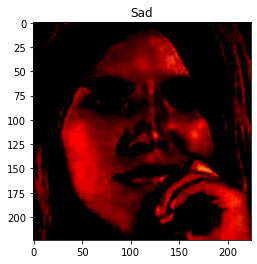

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


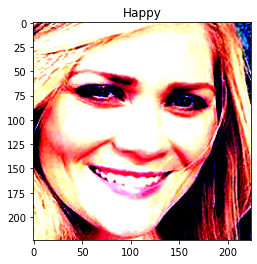

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


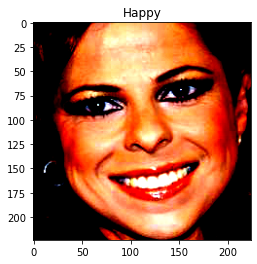

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


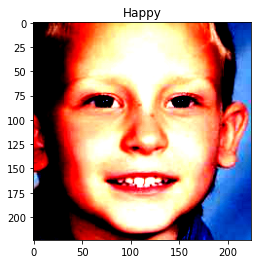

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


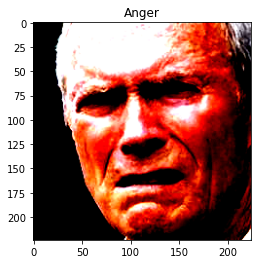

In [6]:
classes=['Neutral','Happy','Sad','Surprise','Fear','Disgust','Anger','Contempt']
for i in range(56,61):
    image,label=train_data[i]
    plt.title(classes[int(label)])
    plt.imshow(image.permute(1,2,0))
    plt.show()

In [8]:
# stats of
print(type(image))
print(type(label))
print(image.shape)
print(label.shape)
print(image.dtype)
print(label.dtype)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
torch.Size([])
torch.float32
torch.float32


In [17]:
train_loader=torch.utils.data.DataLoader(train_data,batch_size=4,shuffle=True,num_workers=0)
val_loader=torch.utils.data.DataLoader(val_data,batch_size=4,shuffle=False,num_workers=0)

In [18]:
print(len(train_loader))
print(len(val_loader))

71913
1000


In [19]:
for x,y in train_loader:
  print(type(x),x.dtype,x.shape)
  print(type(y),y.dtype,y.shape)
  break

<class 'torch.Tensor'> torch.float32 torch.Size([4, 3, 224, 224])
<class 'torch.Tensor'> torch.float32 torch.Size([4])


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [37]:
vgg=torchvision.models.vgg16(pretrained=True)


In [35]:
# Freezing layers except last 4
def vgg16_model():
    features=list(vgg.features)[:30]
    for layer in features[:23]:
        for p in layer.parameters():
            p.requires_grad=False
    return nn.Sequential(*features)

In [36]:
vgg16_model()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si